# WeatherShow

### import

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import datetime
from statistics import mean, median,variance,stdev
from tqdm import tqdm_notebook as tqdm

from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.layers.recurrent import LSTM
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

Using TensorFlow backend.


## RDP

(2, 1000)
(2, 9)


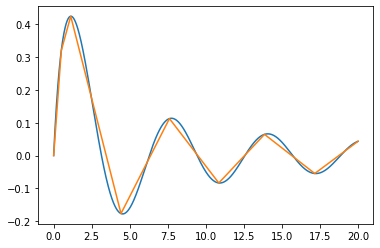

1000
2


In [3]:



def rdp(allPoints, epsilon):
    allPoints = allPoints.transpose()
    #print(epsilon)
    startID = 0
    endID = len(allPoints)-1
    #print(startID)
    #print(endID)
    rdpPoints = []
    rdpPoints.append(allPoints[startID])
    rdpPoints = rdpIn(startID, endID, allPoints, rdpPoints, epsilon)
    rdpPoints.append(allPoints[endID])
    return np.array(rdpPoints).transpose()

def rdpIn(startID, endID, allPoints, rdpPoints, epsilon):
    nextID = findFurthest(allPoints, startID, endID, epsilon)
    if nextID > 0:
        if startID != nextID:
            rdpIn(startID, nextID, allPoints, rdpPoints, epsilon)
        rdpPoints.append(allPoints[nextID])
        if endID != nextID:
            rdpIn(nextID, endID, allPoints, rdpPoints, epsilon)
    return rdpPoints

def findFurthest(points, a, b, epsilon):
    maxDist = 0
    findID = -1;
    for i in range(a+1,b):
        tempDist = lineDist(points[i], points[a], points[b])
        if tempDist > maxDist:
            maxDist = tempDist
            findID = i
    #print(epsilon)
    #print(a)
    #print(findID)
    #print(maxDist)
    if maxDist > epsilon:
        return findID
    else:
        return -1

def lineDist(c, a, b):
    return np.linalg.norm(c - scalarProjection(c, a, b))

def scalarProjection(p, a, b):
    ap = p-a
    ab = b-a
    ab = normalize(ab)
    return a+ab*ap.dot(ab)

def normalize(v, axis=-1, order=2):
    l2 = np.linalg.norm(v, ord = order, axis=axis, keepdims=True)
    l2[l2==0] = 1
    return v/l2

dataLen = 1000
pos = np.zeros((2, dataLen))
pos[0, :] = np.linspace(0, 20, dataLen)
pos[1, :] = np.sin(pos[0,:])/(1+pos[0,:])
print(pos.shape)
rdped = np.array(rdp(pos, 0.1))
print(rdped.shape)
plt.plot(pos[0,:], pos[1,:])
plt.plot(rdped[0,:], rdped[1,:])
plt.show()
print(dataLen)
print(len(rdped))

### getData

In [4]:
from socket import *
import socket
import time
PORT = 5000
BUFFER_SIZE = 1024

with socket.socket(socket.AF_INET, socket.SOCK_STREAM) as s:
    s.connect(('nekodigi.local', PORT))
    s.settimeout(1)
    #data = input('Please input > ')
    s.send('request'.encode())
    msg = ''
    startTime = time.time()
    for i in range(1000):
        try:
            data = s.recv(BUFFER_SIZE).decode('utf-8')
            msg = msg + data
            #print(len(data))
        except timeout:
            break
with open('WeatherData.txt', mode='w') as f:
    f.write(msg)

print('complete!')

complete!


### showData


(2, 50)


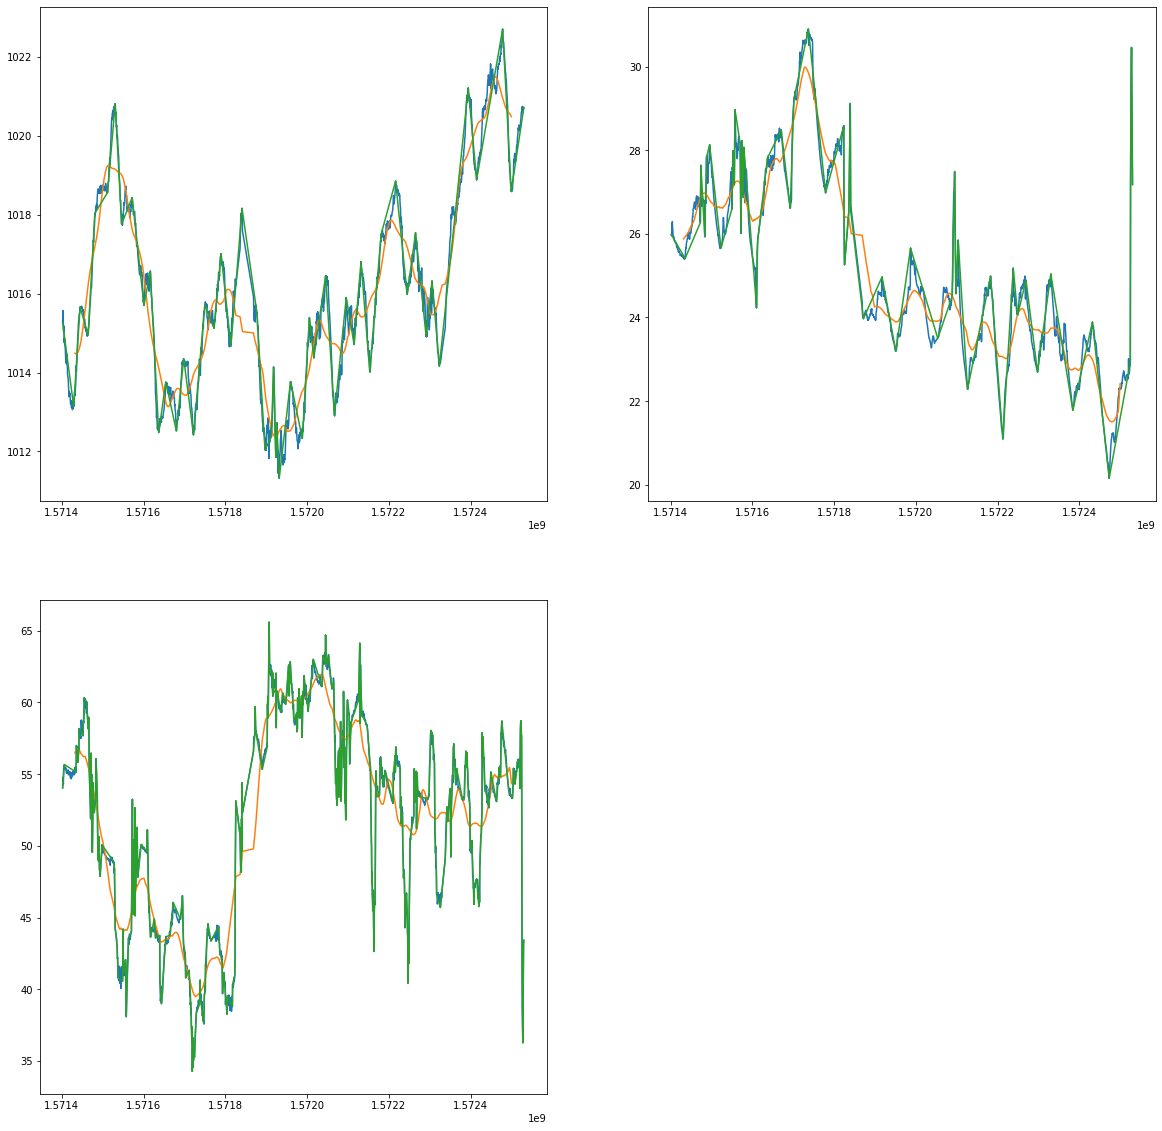

In [5]:
makeNomal = True
#Thinning------------------
Thinning=10
#Smooth----------------------
makeSmooth = True
smoothSample = 100;
sampleInterval = 1;
#Rdp---------------------------
makeRdp = True
pres_epsilon = 1
temp_epsilon = 1
hum_epsilon = 1

readDatas = None
with open('WeatherData.txt') as f:
    readDatas = f.read().split('\n')

timeAxis = []
presAxis = []
tempAxis = []
humAxis = []
s_timeAxis = None
s_presAxis = None
s_tempAxis = None
s_humAxis = None
totalData = 0
readCount = 0
for readData in tqdm(readDatas):
    if readData != '' and readCount % Thinning == 0:
        datas = readData.split(',')
        dte = datetime.datetime.strptime(datas[3], '%Y:%m:%d:%H:%M')
        if float(datas[0].strip("\x00")) >= 800:
            timeAxis.append(int(datas[4]))
            presAxis.append(float(datas[0].strip("\x00")))
            tempAxis.append(float(datas[1]))
            humAxis.append(float(datas[2]))
            totalData+=1
    readCount+=1

if makeSmooth:
    s_timeAxis = np.array([])
    s_presAxis = np.array([])
    s_tempAxis = np.array([])
    s_humAxis = np.array([])
    for i in tqdm(range(0, len(timeAxis)-smoothSample, sampleInterval)):
        s_timeAxis = np.append(s_timeAxis, timeAxis[int(i+smoothSample/2)])
        s_presAxis = np.append(s_presAxis, mean(presAxis[i:i+smoothSample:sampleInterval]))
        s_tempAxis = np.append(s_tempAxis, mean(tempAxis[i:i+smoothSample:sampleInterval]))
        s_humAxis = np.append(s_humAxis, mean(humAxis[i:i+smoothSample:sampleInterval]))
if makeRdp:
    rdped_presAxis = rdp(np.stack([timeAxis, presAxis]), pres_epsilon)
    rdped_tempAxis = rdp(np.stack([timeAxis, tempAxis]), temp_epsilon)
    rdped_humAxis = rdp(np.stack([timeAxis, humAxis]), hum_epsilon)
#print(np.stack([timeAxis, presAxis]))
print(rdped_presAxis.shape)
fig = plt.figure(figsize=(20,20))
ax1 = fig.add_subplot(2, 2, 1)
ax2 = fig.add_subplot(2, 2, 2)
ax3 = fig.add_subplot(2, 2, 3)
if makeNomal:
    ax1.plot(timeAxis, presAxis)
    ax2.plot(timeAxis, tempAxis)
    ax3.plot(timeAxis, humAxis)
if makeSmooth:
    ax1.plot(s_timeAxis, s_presAxis)
    ax2.plot(s_timeAxis, s_tempAxis)
    ax3.plot(s_timeAxis, s_humAxis)
if makeRdp:
    ax1.plot(rdped_presAxis[0], rdped_presAxis[1])
    ax2.plot(rdped_tempAxis[0], rdped_tempAxis[1])
    ax3.plot(rdped_humAxis[0], rdped_humAxis[1])
plt.show()

In [ ]:
 #coding: utf-8
 
import smbus
import time
from datetime import datetime
 
bus_number  = 1
i2c_address = 0x76
 
bus = smbus.SMBus(bus_number)
 
digT = []
digP = []
digH = []
 
t_fine = 0.0
 
 
def writeReg(reg_address, data):
    bus.write_byte_data(i2c_address,reg_address,data)
 
def get_calib_param():
    calib = []
     
    for i in range (0x88,0x88+24):
        calib.append(bus.read_byte_data(i2c_address,i))
    calib.append(bus.read_byte_data(i2c_address,0xA1))
    for i in range (0xE1,0xE1+7):
        calib.append(bus.read_byte_data(i2c_address,i))
 
    digT.append((calib[1] << 8) | calib[0])
    digT.append((calib[3] << 8) | calib[2])
    digT.append((calib[5] << 8) | calib[4])
    digP.append((calib[7] << 8) | calib[6])
    digP.append((calib[9] << 8) | calib[8])
    digP.append((calib[11]<< 8) | calib[10])
    digP.append((calib[13]<< 8) | calib[12])
    digP.append((calib[15]<< 8) | calib[14])
    digP.append((calib[17]<< 8) | calib[16])
    digP.append((calib[19]<< 8) | calib[18])
    digP.append((calib[21]<< 8) | calib[20])
    digP.append((calib[23]<< 8) | calib[22])
    digH.append( calib[24] )
    digH.append((calib[26]<< 8) | calib[25])
    digH.append( calib[27] )
    digH.append((calib[28]<< 4) | (0x0F & calib[29]))
    digH.append((calib[30]<< 4) | ((calib[29] >> 4) & 0x0F))
    digH.append( calib[31] )
     
    for i in range(1,2):
        if digT[i] & 0x8000:
            digT[i] = (-digT[i] ^ 0xFFFF) + 1
 
    for i in range(1,8):
        if digP[i] & 0x8000:
            digP[i] = (-digP[i] ^ 0xFFFF) + 1
 
    for i in range(0,6):
        if digH[i] & 0x8000:
            digH[i] = (-digH[i] ^ 0xFFFF) + 1 
 
def readData():
    data = []
    for i in range (0xF7, 0xF7+8):
        data.append(bus.read_byte_data(i2c_address,i))
    pres_raw = (data[0] << 12) | (data[1] << 4) | (data[2] >> 4)
    temp_raw = (data[3] << 12) | (data[4] << 4) | (data[5] >> 4)
    hum_raw  = (data[6] << 8)  |  data[7]
     
    #compensate_T(temp_raw)
    #compensate_P(pres_raw)
    #compensate_H(hum_raw)
    t = compensate_T(temp_raw)
    p = compensate_P(pres_raw)
    h = compensate_H(hum_raw)
    nowTime = datetime.now()
    #print("気圧:" + p + ",温度:" + t + ",湿度:" + h + ",時間:" + str(nowTime.year) + "年" + str(nowTime.month) + "月" + str(nowTime.day) + "日" + str(nowTime.hour) + "時" + str(nowTime.minute) + "分,timestamp:" + str(int(nowTime.timestamp())))
    return p + "," + t + "," + h + "," + str(nowTime.year) + ":" + str(nowTime.month) + ":" + str(nowTime.day) + ":" + str(nowTime.hour) + ":" + str(nowTime.minute) + "," + str(int(nowTime.timestamp()))

 
def compensate_P(adc_P):
    global  t_fine
    pressure = 0.0
     
    v1 = (t_fine / 2.0) - 64000.0
    v2 = (((v1 / 4.0) * (v1 / 4.0)) / 2048) * digP[5]
    v2 = v2 + ((v1 * digP[4]) * 2.0)
    v2 = (v2 / 4.0) + (digP[3] * 65536.0)
    v1 = (((digP[2] * (((v1 / 4.0) * (v1 / 4.0)) / 8192)) / 8)  + ((digP[1] * v1) / 2.0)) / 262144
    v1 = ((32768 + v1) * digP[0]) / 32768
     
    if v1 == 0:
        return 0
    pressure = ((1048576 - adc_P) - (v2 / 4096)) * 3125
    if pressure < 0x80000000:
        pressure = (pressure * 2.0) / v1
    else:
        pressure = (pressure / v1) * 2
    v1 = (digP[8] * (((pressure / 8.0) * (pressure / 8.0)) / 8192.0)) / 4096
    v2 = ((pressure / 4.0) * digP[7]) / 8192.0
    pressure = pressure + ((v1 + v2 + digP[6]) / 16.0)  
 
    #print "pressure : %7.2f hPa" % (pressure/100)
    return "%7.2f" % (pressure/100)
 
 
def compensate_T(adc_T):
    global t_fine
    v1 = (adc_T / 16384.0 - digT[0] / 1024.0) * digT[1]
    v2 = (adc_T / 131072.0 - digT[0] / 8192.0) * (adc_T / 131072.0 - digT[0] / 8192.0) * digT[2]
    t_fine = v1 + v2
    temperature = t_fine / 5120.0
    #print "temp : %-6.2f ℃" % (temperature) 
    return "%.2f" % (temperature) 
 
def compensate_H(adc_H):
    global t_fine
    var_h = t_fine - 76800.0
    if var_h != 0:
        var_h = (adc_H - (digH[3] * 64.0 + digH[4]/16384.0 * var_h)) * (digH[1] / 65536.0 * (1.0 + digH[5] / 67108864.0 * var_h * (1.0 + digH[2] / 67108864.0 * var_h)))
    else:
        return 0
    var_h = var_h * (1.0 - digH[0] * var_h / 524288.0)
    if var_h > 100.0:
        var_h = 100.0
    elif var_h < 0.0:
        var_h = 0.0
    #print "hum : %6.2f ％" % (var_h)
    return "%.2f" % (var_h)
 
def setup():
    osrs_t = 1            #Temperature oversampling x 1
    osrs_p = 1            #Pressure oversampling x 1
    osrs_h = 1            #Humidity oversampling x 1
    mode   = 3            #Normal mode
    t_sb   = 5            #Tstandby 1000ms
    filter = 0            #Filter off
    spi3w_en = 0            #3-wire SPI Disable
 
    ctrl_meas_reg = (osrs_t << 5) | (osrs_p << 2) | mode
    config_reg    = (t_sb << 5) | (filter << 2) | spi3w_en
    ctrl_hum_reg  = osrs_h
 
    writeReg(0xF2,ctrl_hum_reg)
    writeReg(0xF4,ctrl_meas_reg)
    writeReg(0xF5,config_reg)
 
 
setup()
get_calib_param()
 
 
if __name__ == '__main__':
    while True:
        readData()
        time.sleep(1)